In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import metrics,model_selection

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Read dataset
df = pd.read_csv('hotel_booking.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [3]:
df.info() #previewing the dataset datatypes and entry counts 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
# Based on the given dataset description, list the columns that are categorical in terms of their semantics
categorical_columns_semantics = [
    'hotel',
    'is_canceled',
    'arrival_date_year',
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'is_repeated_guest',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'agent',
    'company',
    'customer_type',
    'reservation_status',
    'name',
    'email',
    'phone-number',
    'credit_card'
]

for column in categorical_columns_semantics:
    if column in df.columns:
        df[column] = df[column].astype(str)
        
df.dtypes

hotel                              object
is_canceled                        object
lead_time                           int64
arrival_date_year                  object
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                  object
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

## Summary Statistics for numerical variables

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0
previous_cancellations,119390.0,0.087118,0.844336,0.00,0.00,0.000,0.0,26.0
previous_bookings_not_canceled,119390.0,0.137097,1.497437,0.00,0.00,0.000,0.0,72.0


In [6]:
# Get the summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
hotel,119390,2,City Hotel,79330
is_canceled,119390,2,0,75166
arrival_date_year,119390,3,2016,56707
arrival_date_month,119390,12,August,13877
meal,119390,5,BB,92310
country,119390,178,PRT,48590
market_segment,119390,8,Online TA,56477
distribution_channel,119390,5,TA/TO,97870
is_repeated_guest,119390,2,0,115580
reserved_room_type,119390,10,A,85994


In [7]:
# Reloading the dataset
df = pd.read_csv('hotel_booking.csv')

### Data Preprocessing

#### Dropping columns that are not needed for model building

In [8]:
# Drop the `reservation_status` feature
df = df.drop(['reservation_status'], axis=1)

In [9]:
# Drop the 'reservation_status_date' and 'reservation_status_days_difference' columns
df = df.drop(['reservation_status_date'], axis=1)

In [10]:
df = df.drop(['assigned_room_type'], axis=1)
# Drop the `arrival_date_year` feature
df = df.drop(['arrival_date_year'], axis=1)

In [11]:
# Create a new feature representing the number of bookings made by each guest (based on the name)
df['number_of_bookings'] = df.groupby('name')['name'].transform('count')

# Drop the original 'name' feature and other high-cardinality features
df = df.drop(['name', 'country', 'agent', 'company', 'email', 'phone-number', 'credit_card'], axis=1)

#### Handling missing values

In [12]:
#checking the percentage missing data of entire dataset
print('Missing value percentage',round((df.isnull().sum().sum() / len(df))*100,3),'%')

Missing value percentage 0.003 %


In [13]:
#checking which columns have missing data
missing_col = df.isnull().sum()
missing_col[missing_col > 0]

children    4
dtype: int64

In [14]:
df['children'].value_counts()

0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64

In [15]:
df['children'] = df['children'].fillna(0) #replacing the missing values with the mode of the columns

df['children'].isnull().sum() #checking if there are still any missing values present

0

### Encoding

In [16]:
# Convert 'arrival_date_month' to numerical values
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['arrival_date_month'] = df['arrival_date_month'].apply(lambda x: months.index(x) + 1)

# One-hot encode the specified columns
one_hot_cols = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 49 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   lead_time                       119390 non-null  int64  
 2   arrival_date_month              119390 non-null  int64  
 3   arrival_date_week_number        119390 non-null  int64  
 4   arrival_date_day_of_month       119390 non-null  int64  
 5   stays_in_weekend_nights         119390 non-null  int64  
 6   stays_in_week_nights            119390 non-null  int64  
 7   adults                          119390 non-null  int64  
 8   children                        119390 non-null  float64
 9   babies                          119390 non-null  int64  
 10  is_repeated_guest               119390 non-null  int64  
 11  previous_cancellations          119390 non-null  int64  
 12  previous_booking

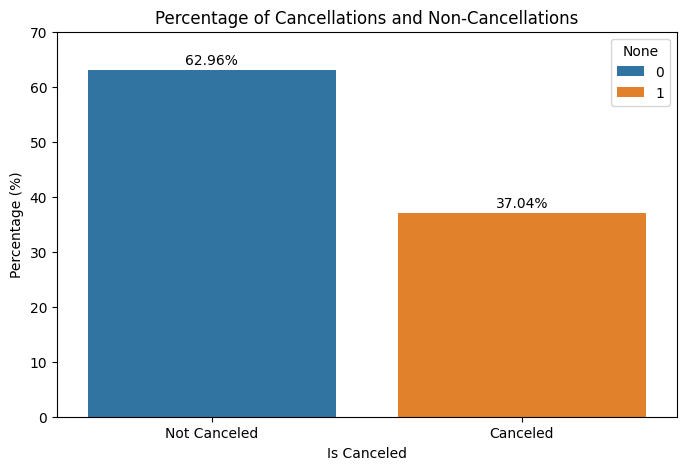

In [17]:
# Calculating the percentage of each class
percentage = df['is_canceled'].value_counts(normalize=True) * 100

# Plotting the percentage of each class
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=percentage.index, y=percentage, hue=percentage.index)
plt.title('Percentage of Cancellations and Non-Cancellations')
plt.xlabel('Is Canceled')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.yticks(ticks=range(0,80,10))

# Displaying the percentage on the bars
for i, p in enumerate(percentage):
    ax.text(i, p + 0.5, f'{p:.2f}%', ha='center', va='bottom')

plt.show()

### Splitting the dataset

In [18]:
# Define the features (X) and the output labels (y)
X = df.drop('is_canceled', axis=1)
y = df['is_canceled'] 

In [19]:
X['is_repeated_guest'] = X['is_repeated_guest'].astype(int)
X['is_repeated_guest'].dtype
y = y.astype(int)

In [20]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

### Decision Tree Model

In [21]:
# Define the base DT model
dt_base = DecisionTreeClassifier(random_state=0)

In [22]:
def clf_hyperparametertuning (clf,param,X_train,y_rain, scoring = 'f1', n_splits = 5):
    
    #creating the cross validation object to ensure class distribution is same acrosss all folds
    cv = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state = 0)
    
    #creating the GridSearchCV object
    clf_grid = GridSearchCV(clf,param,cv=cv,scoring = scoring, n_jobs =-1)
    
    #fit the gridsearchCV object to the training dataset
    clf_grid.fit(X_train,y_train)
    
    #get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator
    return clf_grid.best_estimator_, best_hyperparameters
    

In [23]:
# Hyperparameter grid for DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [13, 14, 15],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    
}

In [24]:
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = clf_hyperparametertuning(dt_base, param_grid_dt, X_train, y_train)

In [25]:
best_dt.fit(X_train,y_train) #Fitting the train dataset into the model 
y_pred = best_dt.predict(X_test) #predicting the dependent feature using testing dataset on trained model

In [26]:
def metricvalidation (y_test,y_pred, model):
    cm = confusion_matrix(y_test,y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    print("\n",classification_report(y_test,y_pred))
    
    # Predict probabilities for the positive class (class 1 for binary classification) for both datasets
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]

    # Calculate AUC for training and testing sets
    auc_train = roc_auc_score(y_train, y_train_pred_prob)
    auc_test = roc_auc_score(y_test, y_test_pred_prob)

    # Generate ROC curve for training and testing sets
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Train ROC curve (AUC = {:.2f})'.format(auc_train))
    plt.plot(fpr_test, tpr_test, color='navy', lw=2, label='Test ROC curve (AUC = {:.2f})'.format(auc_test))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

    # Print AUC values
    print("AUC for Training Set:", round(auc_train, 2))
    print("AUC for Testing Set:", round(auc_test, 2))

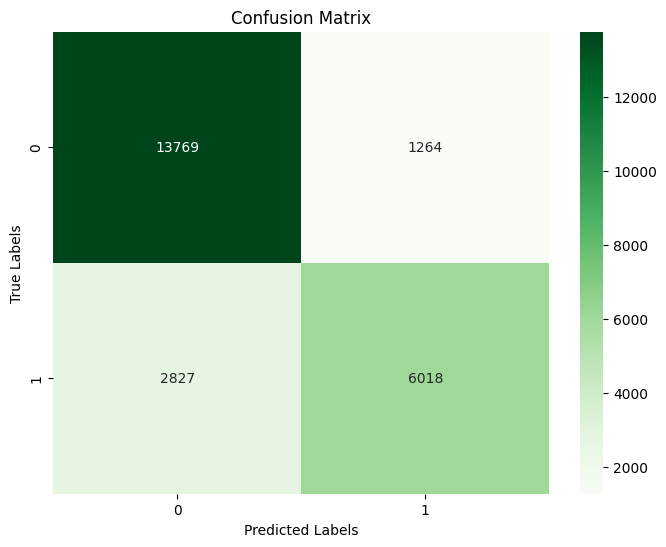


               precision    recall  f1-score   support

           0       0.83      0.92      0.87     15033
           1       0.83      0.68      0.75      8845

    accuracy                           0.83     23878
   macro avg       0.83      0.80      0.81     23878
weighted avg       0.83      0.83      0.82     23878



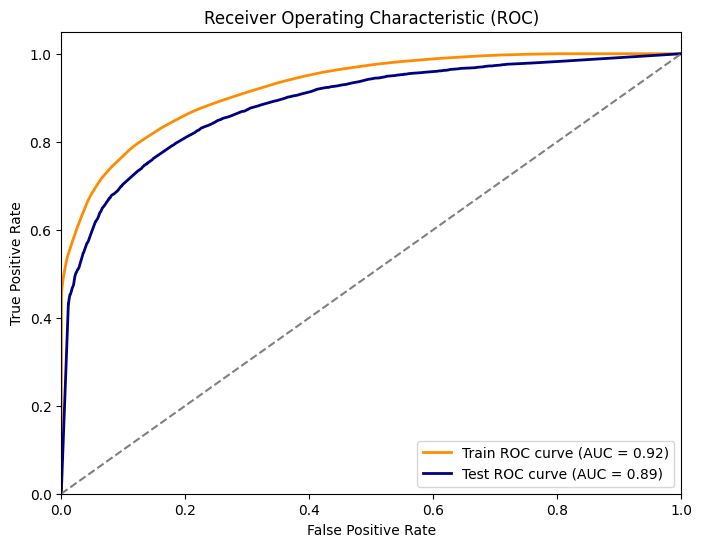

AUC for Training Set: 0.92
AUC for Testing Set: 0.89


In [27]:
metricvalidation(y_test,y_pred,best_dt)

### Random Forest Model

In [28]:
# Define the base RF model
rf_base = RandomForestClassifier(random_state=0, n_jobs=-1)

In [29]:
param_grid_rf = {
    'n_estimators': [100, 150],
    'criterion': ['entropy'],
    'max_depth': [16, 18],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

In [30]:
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = clf_hyperparametertuning(rf_base, param_grid_rf, X_train, y_train)

In [31]:
best_dt.fit(X_train,y_train)
y_pred = best_dt.predict(X_test)

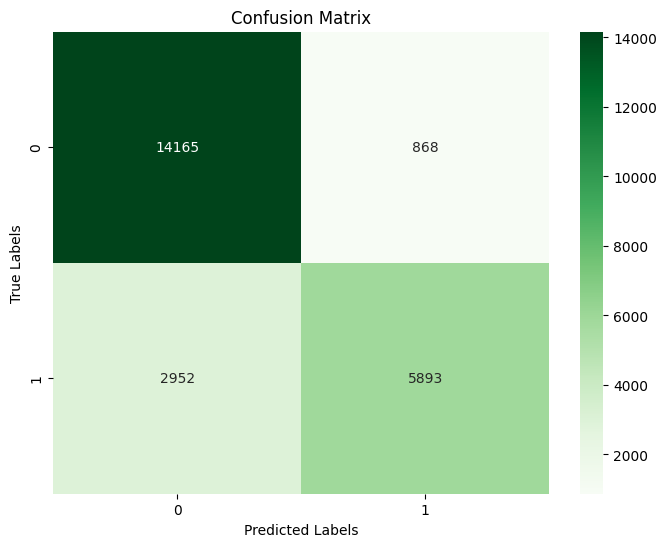


               precision    recall  f1-score   support

           0       0.83      0.94      0.88     15033
           1       0.87      0.67      0.76      8845

    accuracy                           0.84     23878
   macro avg       0.85      0.80      0.82     23878
weighted avg       0.84      0.84      0.83     23878



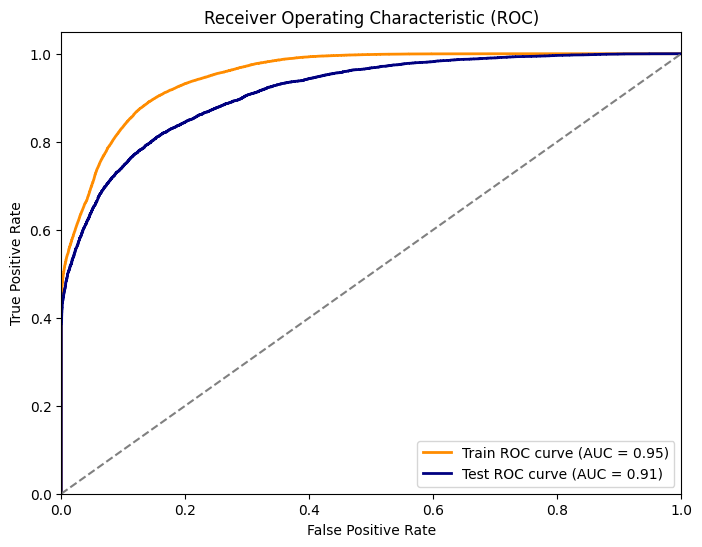

AUC for Training Set: 0.95
AUC for Testing Set: 0.91


In [32]:
metricvalidation(y_test,y_pred,best_dt)

### XGBoost Model

In [33]:
# Define the model
xgb_base = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)

In [34]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [250, 350],
    'learning_rate': [0.01, 0.1],
    'max_depth': [7, 8],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 0.9],
    'scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()]
}

In [35]:
# Call the function for hyperparameter tuning
best_xgb, best_xgb_hyperparams = clf_hyperparametertuning(xgb_base, param_grid_xgb, X_train, y_train)

In [36]:
best_xgb.fit(X_train,y_train)
y_pred = best_xgb.predict(X_test)

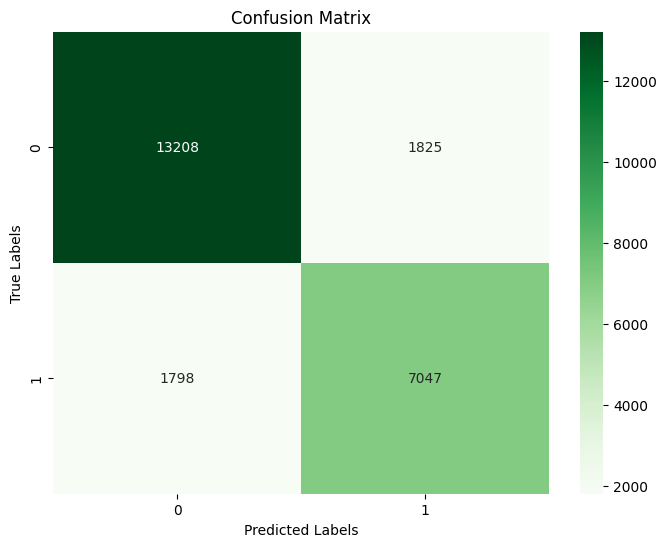


               precision    recall  f1-score   support

           0       0.88      0.88      0.88     15033
           1       0.79      0.80      0.80      8845

    accuracy                           0.85     23878
   macro avg       0.84      0.84      0.84     23878
weighted avg       0.85      0.85      0.85     23878



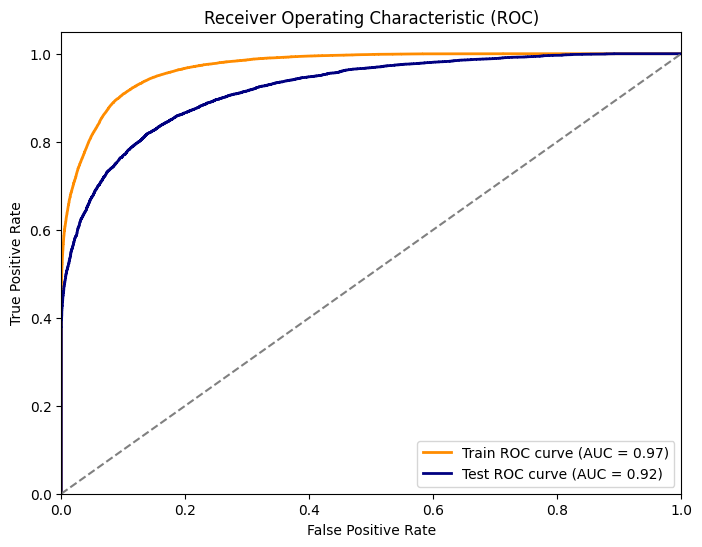

AUC for Training Set: 0.97
AUC for Testing Set: 0.92


In [38]:
metricvalidation(y_test,y_pred,best_xgb)

In [39]:
# Compute feature importances
feature_df = pd.DataFrame({'Feature':best_xgb.feature_names_in_,'Values':best_xgb.feature_importances_})



In [40]:
#displaying the top 5 featues contributing towards classifcation 
feature_df.sort_values(by='Values',ascending=False).reset_index(drop=True).head(5)

,Feature,Values
0,deposit_type_Non Refund,0.659989
1,required_car_parking_spaces,0.100528
2,previous_cancellations,0.048914
3,market_segment_Online TA,0.019580
4,customer_type_Transient,0.011166
